ANS 1: Contour based signature detection and cropping out it from plain paper then enhancing the cropped image.

In [74]:
import cv2
from google.colab.patches import cv2_imshow
import os
import cv2
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops
import numpy as np

%cd /content/sample_data


/content/sample_data


Number of Contours found = 188


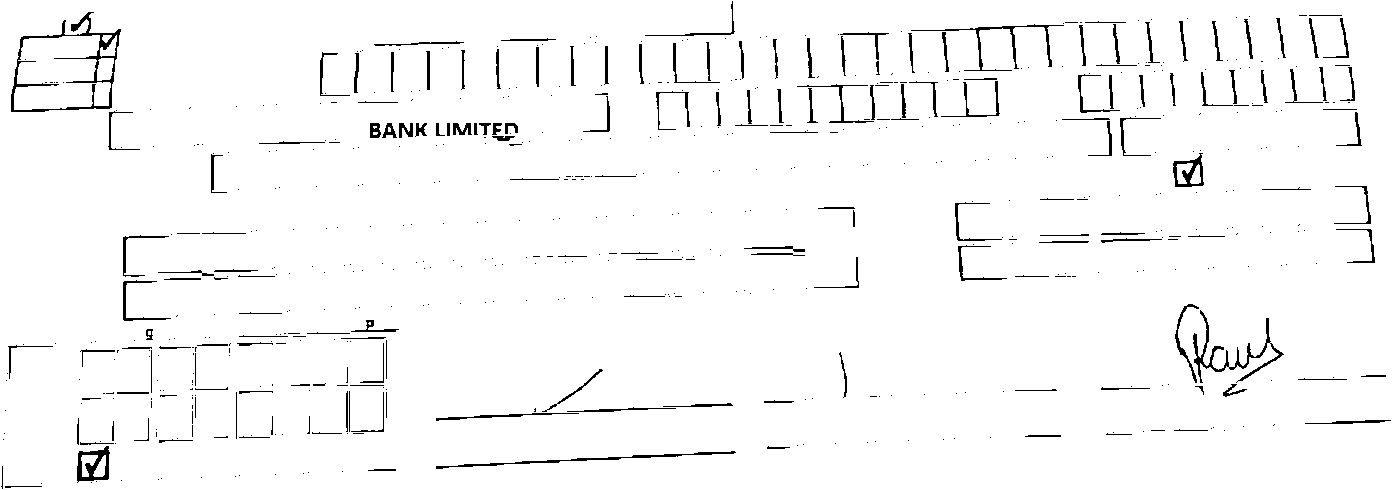

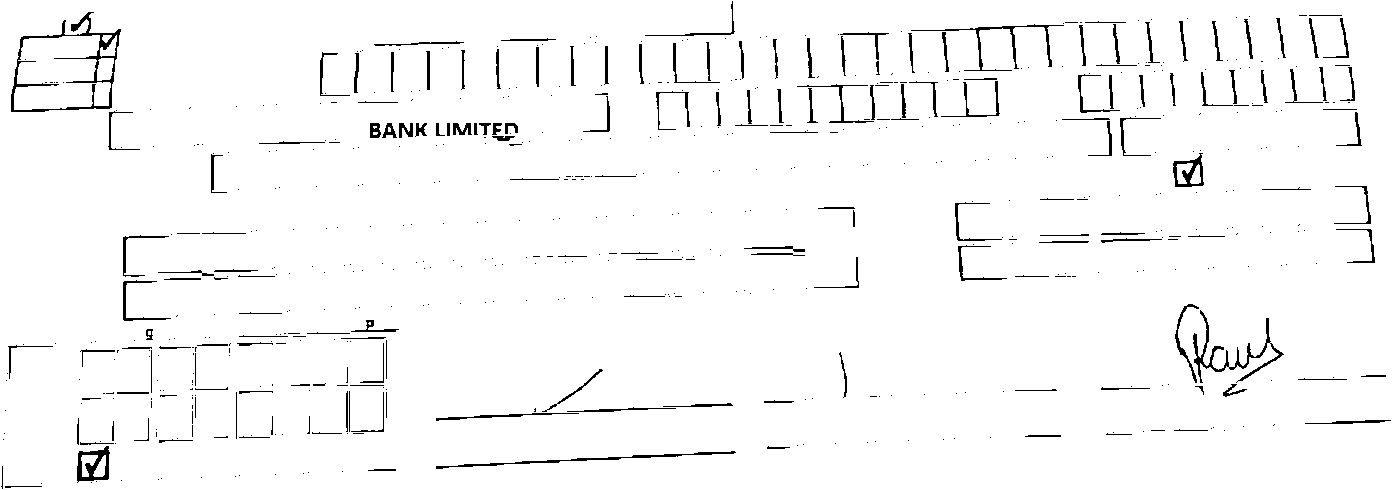

True

In [132]:
name="u.png"
image_name="output/"+name
img=cv2.imread(image_name)

# load the image, convert it to grayscale, and blur it slightly

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

B_image = cv2.Canny(blurred, 10, 200) # Using the Canny edge detector

contours, hierarchy = cv2.findContours(B_image,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
print("Number of Contours found = " + str(len(contours)))
  
# Draw all contours
# -1 signifies drawing all contours
cv2.drawContours(B_image, contours, -1, (0, 255, 0), 3)

CROP_CONTOUR_THRESHOLD=len(contours) # Counting CONTOUR threshold

# Find all shapes and filter out small ones
bboxes=[]
for contour in contours:
  bboxes.append(cv2.boundingRect(contour))
  

bboxes_large = [
    bbox for bbox in bboxes if bbox[2] * bbox[3] > CROP_CONTOUR_THRESHOLD
]


# Find the combined bounding box of all the shapes
# Finding x0,x1,y0 and y1 spatial coordinate values where signature contour is
x0, y0, w, h = bboxes_large[0]
x1 = x0 + w
y1 = y0 + h

for x, y, w, h in bboxes_large[1:]:
    x0 = min(x0, x)
    x1 = max(x1, x + w)
    y0 = min(y0, y)
    y1 = max(y1, y + h)

img=cv2.imread(image_name)
cropped = img[y0:y1, x0:x1]
cv2_imshow(cropped)


#Details Enhancement 
E_image = cv2.detailEnhance(cropped, sigma_s=40, sigma_r=0.15)

cv2_imshow(E_image)
cv2.imwrite("output21/"+name,E_image)


## Conected component analysis

In [ ]:

# read the input image
image1="u.png"
img = cv2.imread('input/'+image1, 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

# the parameters are used to remove small size connected pixels outliar 
constant_parameter_1 = 84
constant_parameter_2 = 250
constant_parameter_3 = 100

# the parameter is used to remove big size connected pixels outliar
constant_parameter_4 = 18

# connected component analysis by scikit-learn framework
blobs = img > img.mean()
blobs_labels = measure.label(blobs, background=1)
image_label_overlay = label2rgb(blobs_labels, image=img)

fig, ax = plt.subplots(figsize=(10, 6))


the_biggest_component = 0
total_area = 0
counter = 0
average = 0.0
for region in regionprops(blobs_labels):
    if (region.area > 10):
        total_area = total_area + region.area
        counter = counter + 1
    # print region.area # (for debugging)
    # take regions with large enough areas
    if (region.area >= 250):
        if (region.area > the_biggest_component):
            the_biggest_component = region.area

average = (total_area/counter)
print("the_biggest_component: " + str(the_biggest_component))
print("average: " + str(average))

# experimental-based ratio calculation, modify it for your cases
# a4_small_size_outliar_constant is used as a threshold value to remove connected outliar connected pixels
a4_small_size_outliar_constant = ((average/constant_parameter_1)*constant_parameter_2)+constant_parameter_3
print("a4_small_size_outliar_constant: " + str(a4_small_size_outliar_constant))

# experimental-based ratio calculation, modify it for your cases
# a4_big_size_outliar_constant is used as a threshold value to remove outliar connected pixels
# are bigger than a4_big_size_outliar_constant for A4 size scanned documents
a4_big_size_outliar_constant = a4_small_size_outliar_constant*constant_parameter_4
print("a4_big_size_outliar_constant: " + str(a4_big_size_outliar_constant))

# remove the connected pixels are smaller than a4_small_size_outliar_constant
pre_version = morphology.remove_small_objects(blobs_labels, a4_small_size_outliar_constant)
# remove the connected pixels are bigger than threshold a4_big_size_outliar_constant 
# to get rid of undesired connected pixels such as table headers and etc.
component_sizes = np.bincount(pre_version.ravel())
too_small = component_sizes > (a4_big_size_outliar_constant)
too_small_mask = too_small[pre_version]
pre_version[too_small_mask] = 0
# save the the pre-version which is the image is labelled with colors
# as considering connected components
plt.imsave('pre_version.png', pre_version)

# read the pre-version
img = cv2.imread('pre_version.png', 0)
# ensure binary
img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# save the the result

cv2.imwrite("output/"+image1, img)




# Horizontal and vertical lines removal

# Load image, grayscale, Gaussian blur, Otsu's threshold

image_name="output/"+image1
image = cv2.imread(image_name)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
horizontal_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

# Detect vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
vertical_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

# Combine masks and remove lines
table_mask = cv2.bitwise_or(horizontal_mask, vertical_mask)
image[np.where(table_mask==255)] = [255,255,255]


cv2.imwrite('output/'+image1, image)
os.remove("pre_version.png") 